In [1]:
import os
from pathlib import Path
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def pad(input, filter_size):
  """
  pads the image based on filter_size
  """
  H, W = filter_size
  pad_H, pad_W = H // 2, W // 2
  padded_image = np.zeros((input.shape[0] + pad_H * 2, input.shape[1] + pad_W * 2))
  padded_image[pad_H:input.shape[0] + pad_H, pad_W:input.shape[1] + pad_W] = input
  return padded_image

def filter_image(input, filter):
    """
    Return the convolution result: image * kernel.
    Caution: use zero-padding.

    Input- image: H x W
           filter: h x w
    Output- convolve: H x W
    """
    padded_image = pad(input, filter.shape)
    output = np.copy(padded_image)
    filter_shape = filter.shape
    half_filter = filter_shape[0] // 2
    for i in range(half_filter, padded_image.shape[0] - half_filter):
        for j in range(half_filter, padded_image.shape[1] - half_filter):
            #output[i, j] = padded_image[i - half_filter:i + half_filter + 1, j - half_filter:j + half_filter + 1] @ filter
            output[i, j] = padded_image[i - half_filter:i + half_filter + 1, j - half_filter:j + half_filter + 1].flatten() @ filter.flatten()

    return output

In [3]:
def generate_gaussian(sigma):
    """
    Return kernel of appropriate size
    Caution: coefficients must sum to 1

    Input- sigma: scalar (should be positive but it will be squared anyway)
    Output- kernel: W x W (no need to return W)
    """
    size = (6 * int(sigma)) + 1
    x, y = np.meshgrid(np.linspace(-1, 1, size), np.linspace(-1, 1, size))
    one_d_gauss = lambda x: 1/(2*np.pi*sigma**2) * np.exp(-x**2/(2*sigma**2))

    kernel = one_d_gauss(x) * one_d_gauss(y)
    kernel /= kernel.sum()
    return kernel


In [4]:
def templ_sad(canvas, template, sigma=None, downsampling_factor=None):
    """
    Input- image: H x W
    Input- template: h x w
    Output - coordinates of the best match
    """

    curr_best = np.inf
    tx = 0
    ty = 0

    # apply gaussian filter to image and template
    if not sigma:
      filtered_image = canvas
      filtered_template = template
      half_filter = 0
    else:
      if not downsampling_factor:
        print("need downsampling factor")
        exit()
      gauss_filter = generate_gaussian(sigma)
      filtered_image = downsampling(filter_image(canvas, gauss_filter), downsampling_factor)
      filtered_template = filter_image(template, gauss_filter)
      half_filter = gauss_filter.shape[0] // 2


    ht = np.zeros(filtered_image.shape)
    #sum of absolute diff
    sad = lambda x, y: np.sum(np.abs(x - y))
    # iterate through every pixel and calculate its cost function
    # based on sum of absolute difference
    for i in range(half_filter, filtered_image.shape[0] - filtered_template.shape[0] - half_filter):
        for j in range(half_filter, filtered_image.shape[1] - filtered_template.shape[1] - half_filter):
          curr_cost = sad(filtered_image[i:i + filtered_template.shape[0], j:j + filtered_template.shape[1]], filtered_template)
          ht[i, j] = curr_cost
          # keep updating the minimum cost and pixel co-ordinates for the window.
          if curr_cost < curr_best:
            curr_best = curr_cost
            tx = i
            ty = j

    ax = sns.heatmap(ht, cmap='viridis')
    ax.set(xticks=[],xticklabels=[], xlabel=None, yticks=[], yticklabels=[], ylabel=None)
    plt.title("SAD Heatmap")
    plt.show()
    print('SAD: Found template at ' + repr(tx) + ' ' + repr(ty) + ' with cost ' + repr(curr_best))

    return tx, ty

def hide_matched_template(image, tx, ty, h, w):
  image[tx:tx + h, ty:ty + w] = 255
  return image

def bounding_box(image, tx, ty, h, w):
  # draw vertical lines
  for i in range(h):
    image[i+tx, ty] = 0
    image[i+tx, ty+w] = 0
  # draw horizontal lines
  for i in range(w):
    image[tx, ty+i] = 0
    image[tx+h, ty+i] = 0
  return image


In [5]:
def downsampling(image, factor):
  return image[::factor, ::factor]

In [6]:
def templ_ncc(canvas, template, sigma=None, downsampling_factor=None):
    """
    Input- image: H x W
    Input- template: h x w
    Output - coordinates of the best match
    """

    curr_best = -np.inf
    tx = 0
    ty = 0

    # perform gaussian smoothening
    # apply gaussian filter to image and template
    if not sigma:
      filtered_image = canvas
      filtered_template = template
      half_filter = 0
    else:
      if not downsampling_factor:
        print("need downsampling factor")
        exit()
      gauss_filter = generate_gaussian(sigma)
      filtered_image = downsampling(filter_image(canvas, gauss_filter), downsampling_factor)
      filtered_template = filter_image(template, gauss_filter)

      half_filter = gauss_filter.shape[0] // 2


    # ncc function for computing cost
    ncc = _ncc(filtered_template)

    ht = np.zeros(filtered_image.shape)
    vmin, vmax = -1, 1
    H, W = filtered_image.shape
    h, w = filtered_template.shape

    for i in range(half_filter, H - filtered_template.shape[0] - half_filter):
        for j in range(half_filter, W - filtered_template.shape[1] - half_filter):
          curr_cost = ncc(filtered_image[i:i+h, j:j+w])
          ht[i, j] = curr_cost
          if curr_cost > curr_best:
            curr_best = curr_cost
            tx = i
            ty = j


    ax = sns.heatmap(ht, cmap='viridis', vmin=vmin, vmax=vmax)
    ax.set(xticks=[],xticklabels=[], xlabel=None, yticks=[], yticklabels=[], ylabel=None)
    plt.title("NCC Heatmap")
    plt.show()

    print('NCC: Found template at ' + repr(tx) + ' ' + repr(ty) + ' with score ' + repr(curr_best))
    return tx, ty

def _ncc(filtered_template):
  template_mean_adjusted = (filtered_template.mean() - filtered_template)
  template_mean_adjusted_sq = np.sqrt(np.sum(template_mean_adjusted**2))

  def inner_func(selected_canvas):
    selected_canvas_mean_adjusted = selected_canvas.mean() - selected_canvas
    selected_canvas_mean_adjusted_sq = np.sqrt(np.sum(selected_canvas_mean_adjusted**2))

    num = np.sum(template_mean_adjusted * selected_canvas_mean_adjusted)
    den = np.sum(template_mean_adjusted_sq * selected_canvas_mean_adjusted_sq)
    return num/(den+1e-10)

  return inner_func


In [7]:
def imshow(image, *args, **kwargs):
    if len(image.shape) == 3:
      # Height, width, channels
      # Assume BGR, do a conversion since
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    else:
      # Height, width - must be grayscale
      # convert to RGB, since matplotlib will plot in a weird colormap (instead of black = 0, white = 1)
      image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    # Draw the image
    plt.imshow(image, *args, **kwargs)
    # We'll also disable drawing the axes and tick marks in the plot, since it's actually an image
    plt.axis('off')
    # Make sure it outputs
    plt.show()

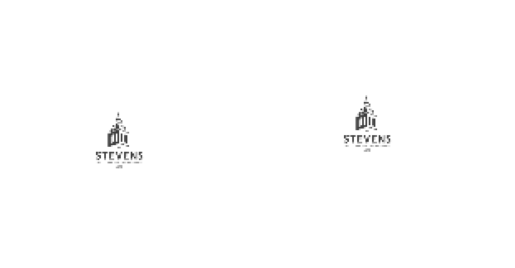

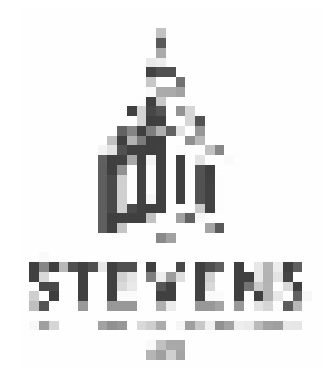

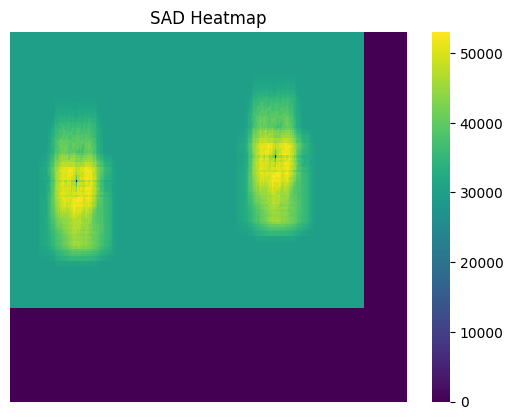

SAD: Found template at 50 200 with cost 958


NCC: Found template at 50 200 with score 0.9999659478599527


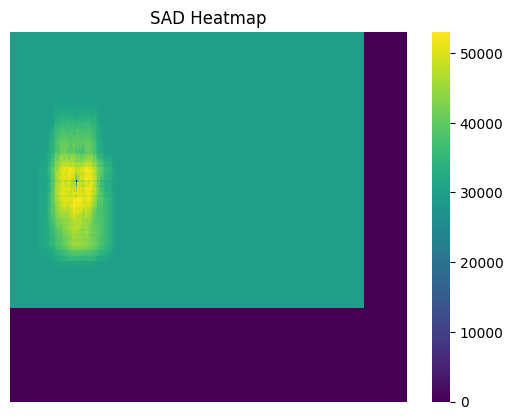

SAD: Found template at 60 50 with cost 958


NCC: Found template at 60 50 with score 0.9999659478599527
Patterns detected in SAD Template Matching


Patterns detected in NCC Template Matching


In [8]:
# Simple Template Matching
templ_image = cv2.imread("logo38.png")
input_image = cv2.imread("match_clean.png")
# the images are gray scale but png is a 3-channel format
templ_image = cv2.cvtColor(templ_image, cv2.COLOR_BGR2GRAY)
input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2GRAY)
imshow(input_image)
imshow(templ_image)

def detect_template(input_image, templ_image):
  sad_positions = list()
  ncc_positions = list()
  sad_matching_image = np.copy(input_image)
  ncc_matching_image = np.copy(input_image)
  sad_template = templ_image.copy()
  ncc_template = templ_image.copy()

  for t in range(2):
    sad_tx, sad_ty = templ_sad(sad_matching_image, sad_template)
    sad_positions.append((sad_tx, sad_ty))
    sad_matching_image = hide_matched_template(sad_matching_image, sad_tx, sad_ty, sad_template.shape[0], sad_template.shape[1])

    ncc_tx, ncc_ty = templ_ncc(ncc_matching_image, ncc_template)
    ncc_positions.append((ncc_tx, ncc_ty))
    ncc_matching_image = hide_matched_template(ncc_matching_image, ncc_tx, ncc_ty, ncc_template.shape[0], ncc_template.shape[1])

  print("Patterns detected in SAD Template Matching")
  bounded_image = np.copy(input_image)
  for tx, ty in sad_positions:
    bounded_image = bounding_box(bounded_image, tx, ty, templ_image.shape[0], templ_image.shape[1])

  imshow(bounded_image)


  print("Patterns detected in NCC Template Matching")
  bounded_image = np.copy(input_image)
  for tx, ty in ncc_positions:
    bounded_image = bounding_box(bounded_image, tx, ty, templ_image.shape[0], templ_image.shape[1])

  imshow(bounded_image)

detect_template(input_image, templ_image)

SAD: Found template at 60 50 with cost 5452


NCC: Found template at 50 200 with score 0.5633679436484315


SAD: Found template at 50 200 with cost 6858


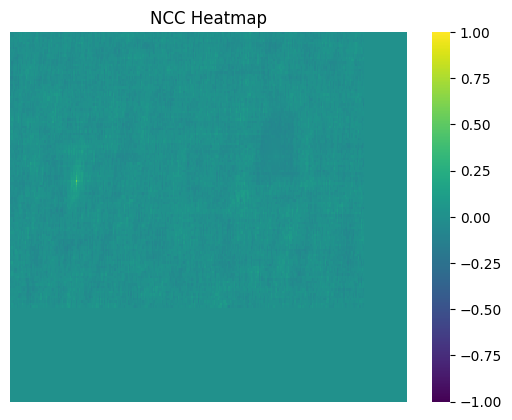

NCC: Found template at 60 50 with score 0.5630163716678622
Patterns detected in SAD Template Matching


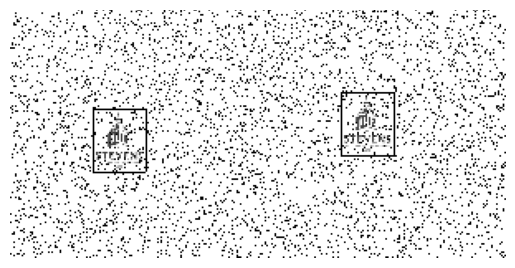

Patterns detected in NCC Template Matching


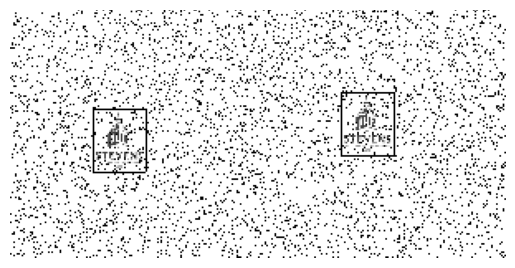

SAD: Found template at 60 50 with cost 11531


NCC: Found template at 60 50 with score 0.3905078835697093


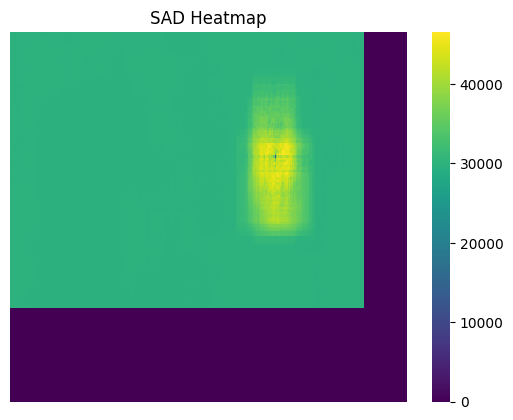

SAD: Found template at 50 200 with cost 13082


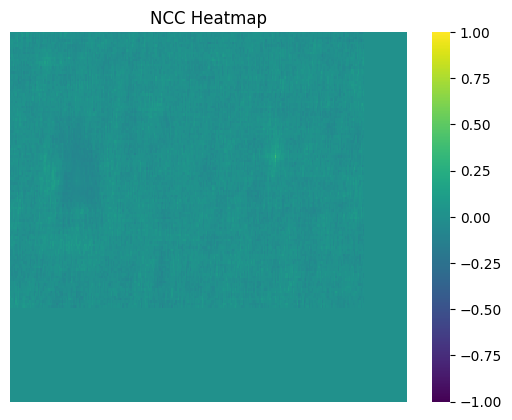

NCC: Found template at 50 200 with score 0.3808010238293023
Patterns detected in SAD Template Matching


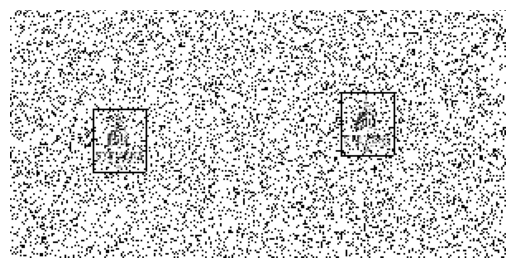

Patterns detected in NCC Template Matching


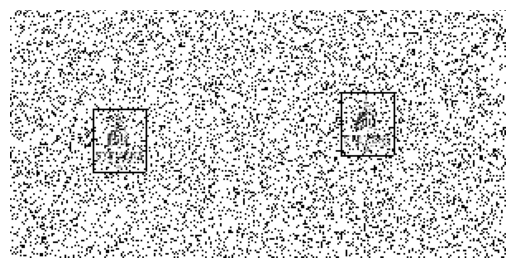

SAD: Found template at 60 50 with cost 14903


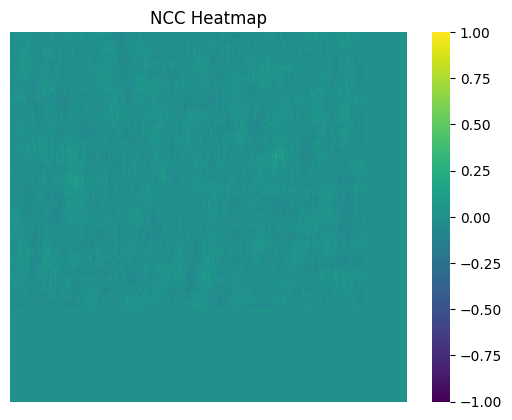

NCC: Found template at 60 50 with score 0.28894647148317404


SAD: Found template at 50 200 with cost 16395


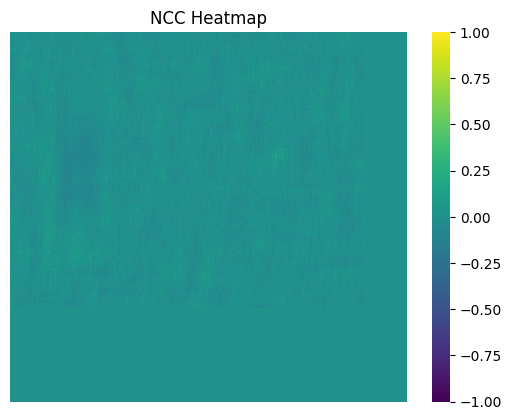

NCC: Found template at 50 200 with score 0.23557908637351532
Patterns detected in SAD Template Matching


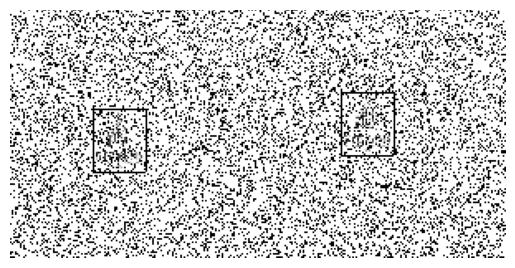

Patterns detected in NCC Template Matching


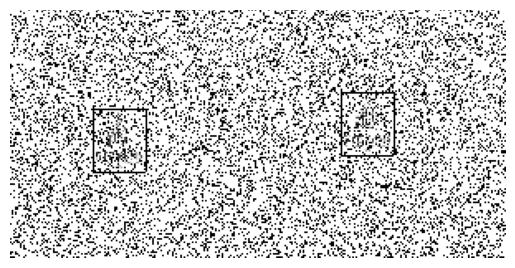

SAD: Found template at 60 50 with cost 18334


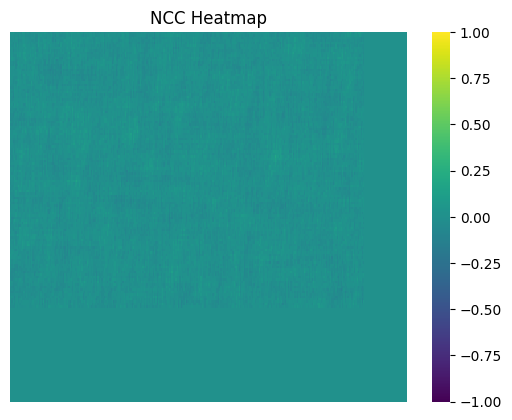

NCC: Found template at 50 200 with score 0.19138808420187967


SAD: Found template at 50 200 with cost 20566


NCC: Found template at 60 50 with score 0.16871542633523848
Patterns detected in SAD Template Matching


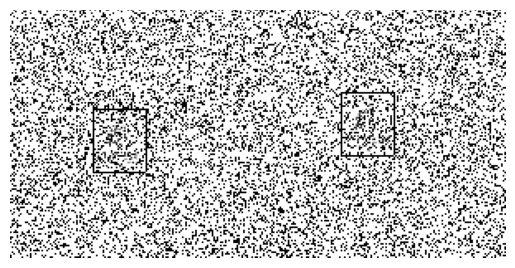

Patterns detected in NCC Template Matching


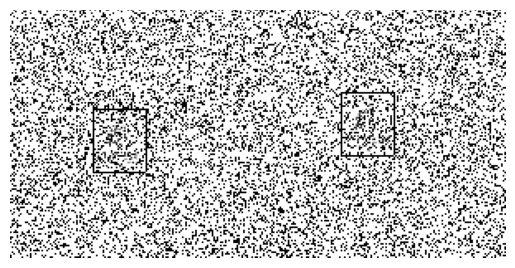

SAD: Found template at 60 50 with cost 21096


NCC: Found template at 50 200 with score 0.1448056203073675


SAD: Found template at 50 200 with cost 21666


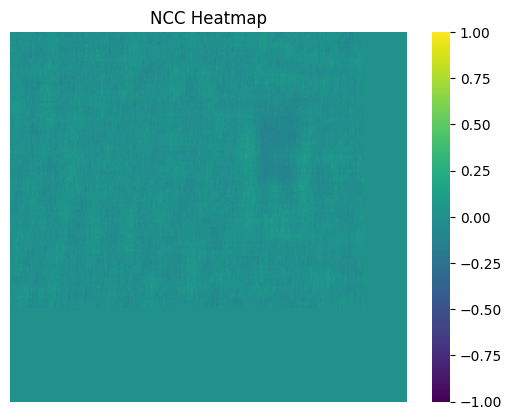

NCC: Found template at 49 178 with score 0.16035134742858728
Patterns detected in SAD Template Matching


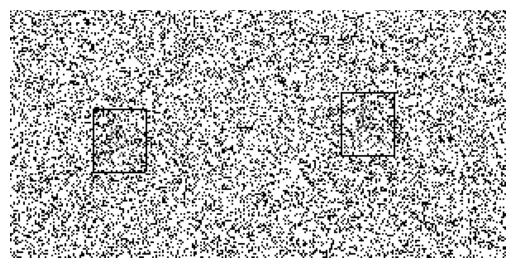

Patterns detected in NCC Template Matching


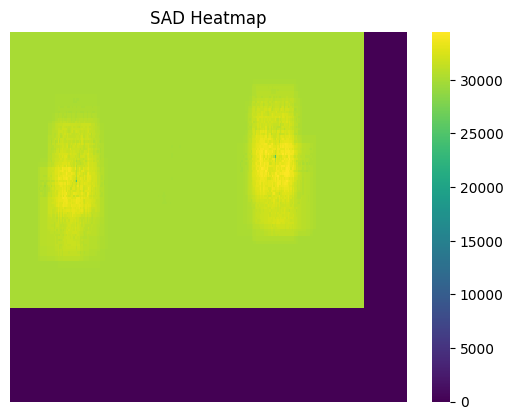

SAD: Found template at 50 200 with cost 24762


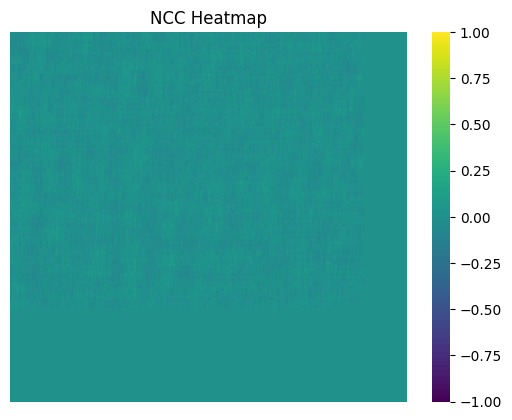

NCC: Found template at 16 19 with score 0.13890216767934238


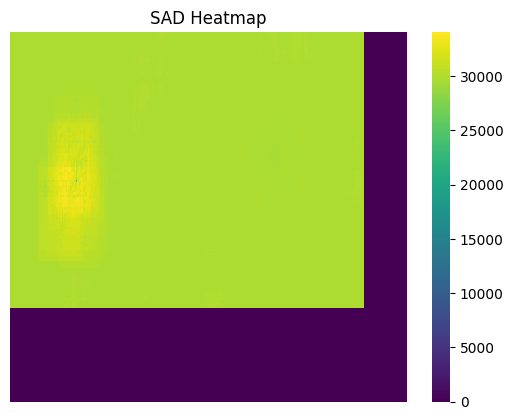

SAD: Found template at 60 50 with cost 25265


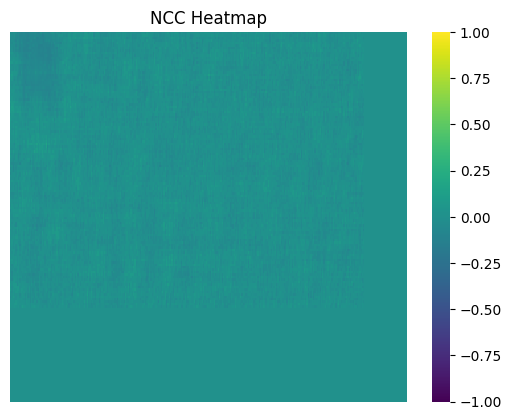

NCC: Found template at 45 27 with score 0.16432915700586256
Patterns detected in SAD Template Matching


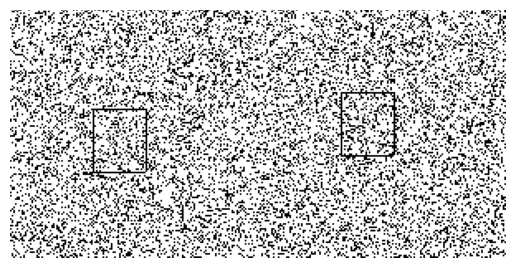

Patterns detected in NCC Template Matching


SAD: Found template at 50 200 with cost 27537


NCC: Found template at 56 250 with score 0.11588130295217193


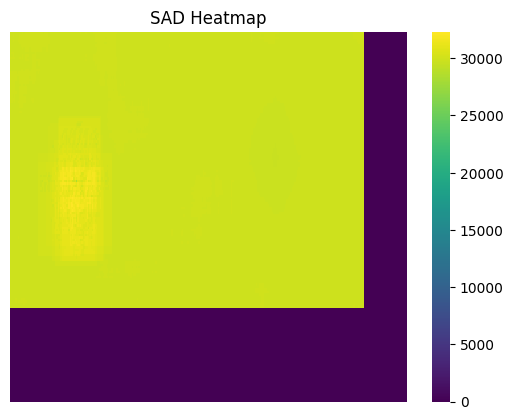

SAD: Found template at 60 50 with cost 28453


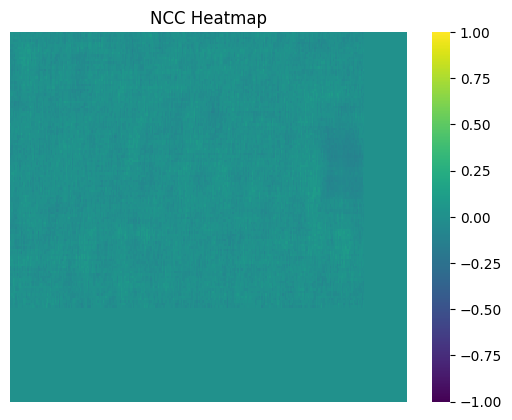

NCC: Found template at 87 253 with score 0.12345300616216692
Patterns detected in SAD Template Matching


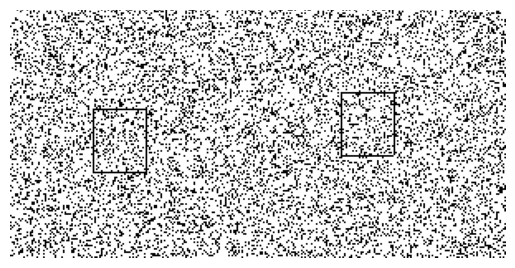

Patterns detected in NCC Template Matching


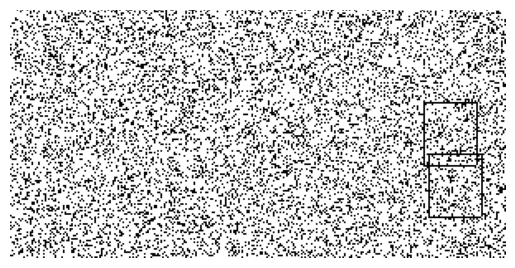

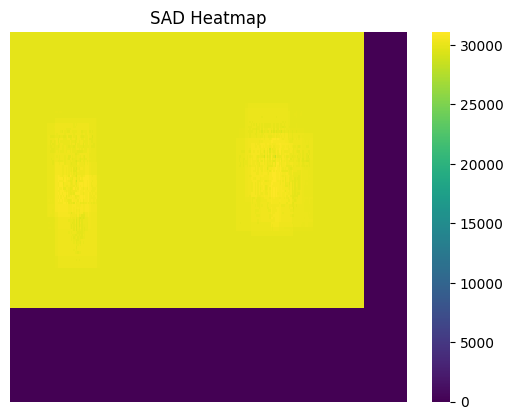

SAD: Found template at 50 200 with cost 28536


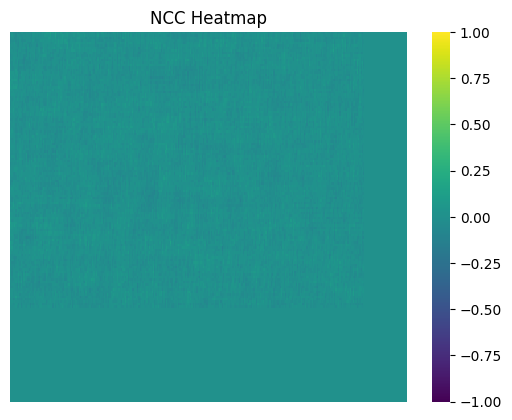

NCC: Found template at 85 121 with score 0.14105200906179674


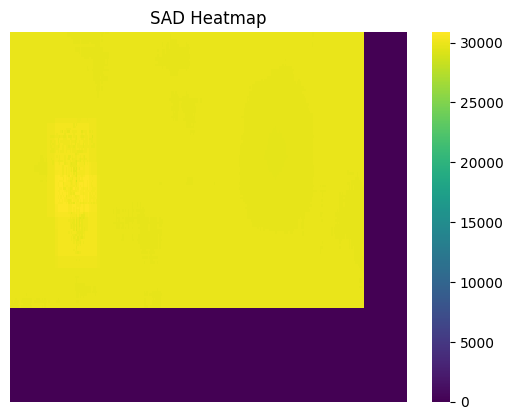

SAD: Found template at 60 50 with cost 29086


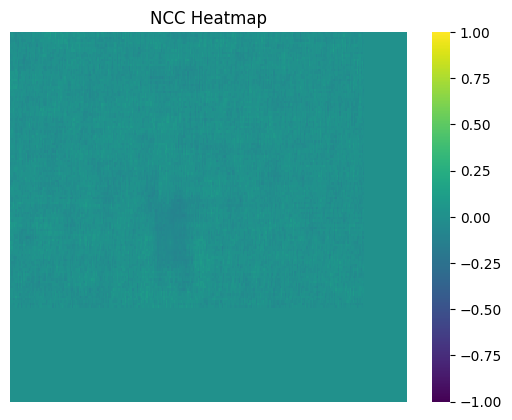

NCC: Found template at 0 34 with score 0.1304013276770326
Patterns detected in SAD Template Matching


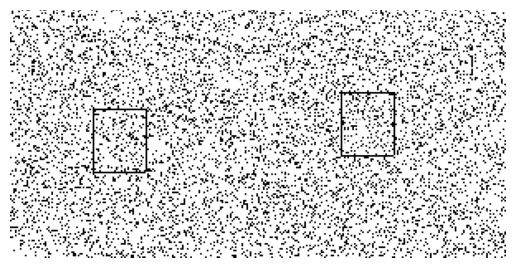

Patterns detected in NCC Template Matching


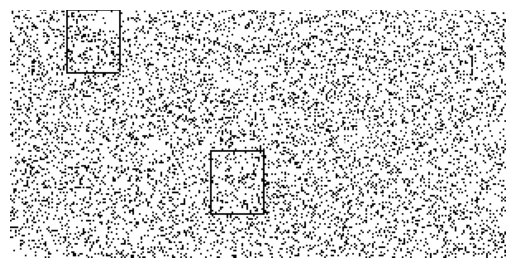

In [9]:
for i in range(18):
  templ_image = cv2.cvtColor(cv2.imread("logo38.png"), cv2.COLOR_BGR2GRAY)
  img_path = Path("match_images/match{}.png".format(i))
  if img_path.exists():
    input_image = cv2.cvtColor(cv2.imread(str(img_path)), cv2.COLOR_BGR2GRAY)
    detect_template(input_image, templ_image)

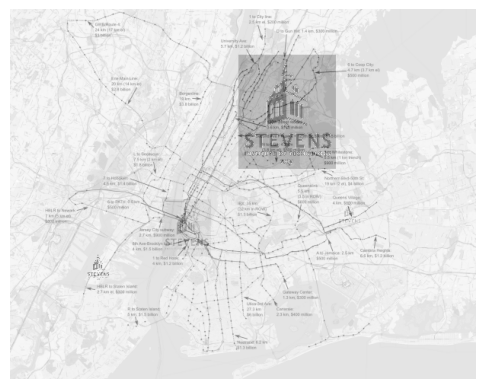

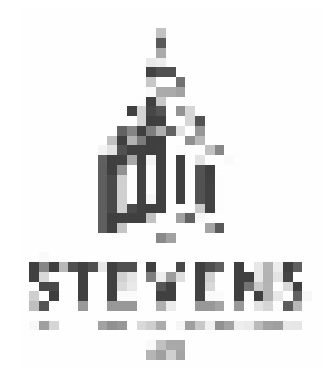

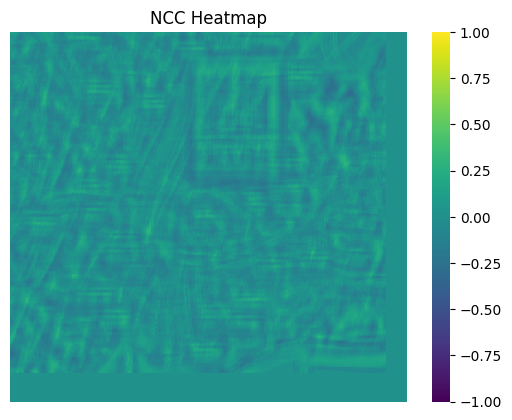

NCC: Found template at 320 100 with score 0.9250413595639998


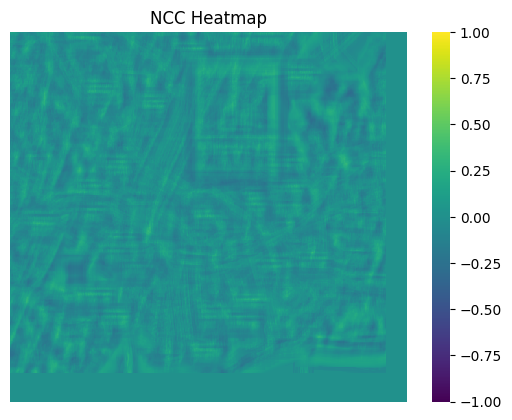

NCC: Found template at 250 430 with score 0.5931177149209546


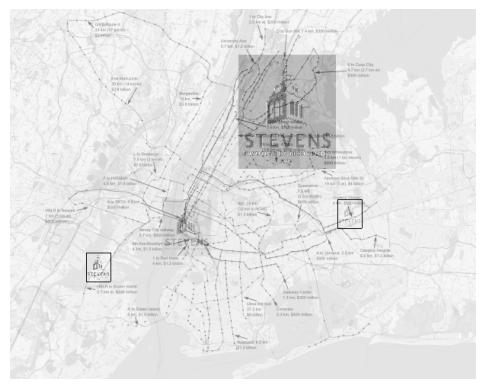

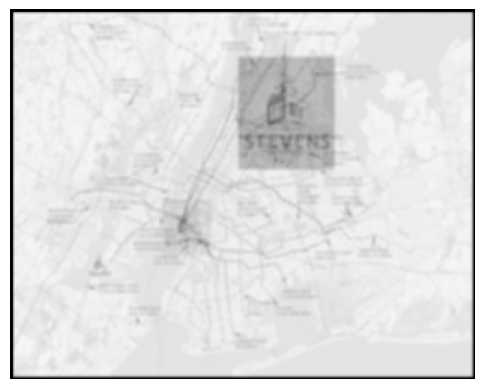

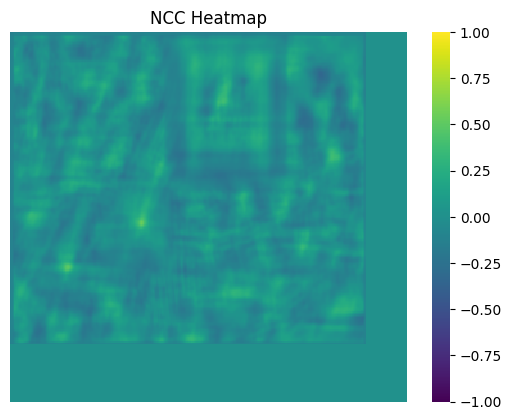

NCC: Found template at 127 102 with score 0.5430404916423034


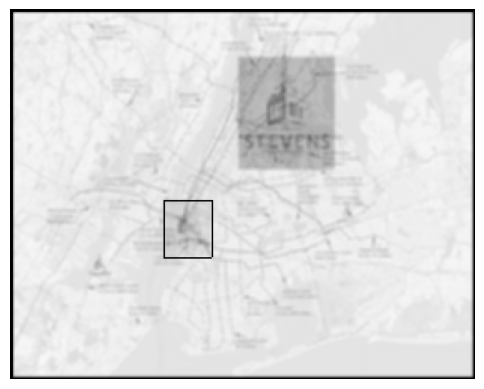

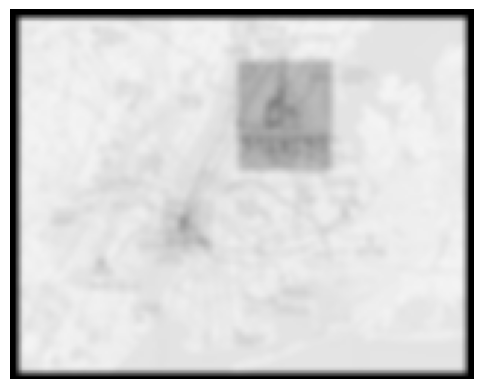

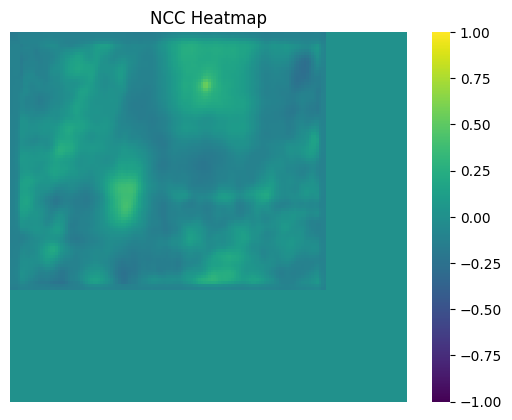

NCC: Found template at 17 78 with score 0.5425219119506607


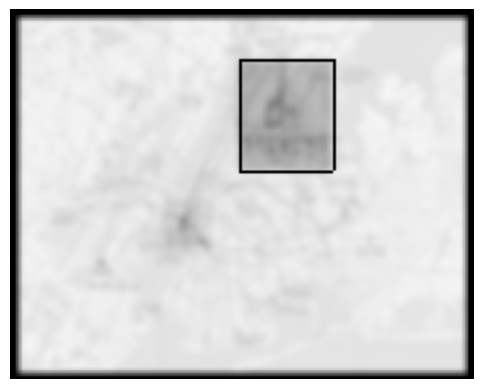

In [10]:
# Multi-scale Template Matching

smalltempl_image = cv2.imread("logo38.png")
smalltempl_image = cv2.cvtColor(smalltempl_image, cv2.COLOR_BGR2GRAY)
map_image = cv2.imread("multiscale.png")
map_image = cv2.cvtColor(map_image, cv2.COLOR_BGR2GRAY)
imshow(map_image)
imshow(smalltempl_image)

def multiscale_template_matching(matching_func, input_image, templ_image, sigma):
  positions = list()
  matching_image = np.copy(input_image)
  template = templ_image.copy()
  for i in range(2):
    tx, ty = matching_func(matching_image, templ_image)
    positions.append((tx, ty))
    matching_image = hide_matched_template(matching_image, tx, ty, template.shape[0], template.shape[1])

  bounded_image = np.copy(input_image)
  for tx, ty in positions:
    bounded_image = bounding_box(bounded_image, tx, ty, templ_image.shape[0], templ_image.shape[1])
  imshow(bounded_image)


  map_ds_2 = downsampling(filter_image(input_image, generate_gaussian(sigma)), 2).astype(np.uint8)
  imshow(map_ds_2)
  tx, ty = matching_func(map_ds_2, templ_image)
  bounded_image = bounding_box(map_ds_2.copy(), tx, ty, templ_image.shape[0], templ_image.shape[1])
  imshow(bounded_image)

  map_ds_4 = downsampling(filter_image(map_ds_2, generate_gaussian(sigma)), 2).astype(np.uint8)
  imshow(map_ds_4)
  tx, ty = matching_func(map_ds_4, templ_image)
  bounded_image = bounding_box(map_ds_4.copy(), tx, ty, templ_image.shape[0], templ_image.shape[1])
  imshow(bounded_image)


sigma = 1.0
multiscale_template_matching(templ_ncc, map_image, smalltempl_image, sigma)

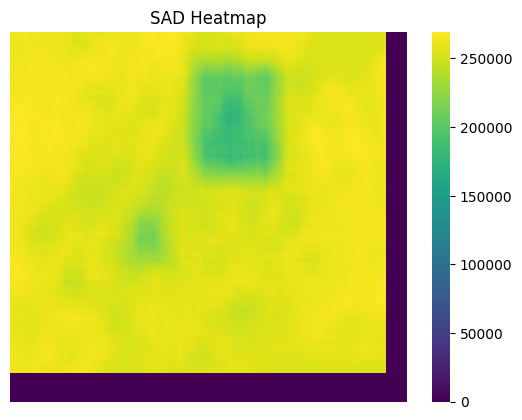

SAD: Found template at 112 338 with cost 171070


SAD: Found template at 112 338 with cost 29625


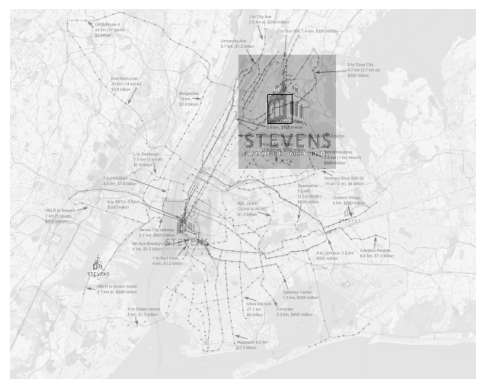

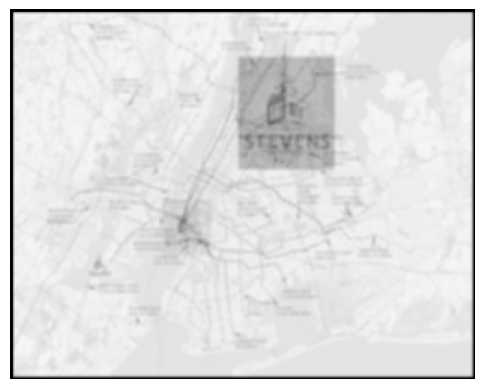

SAD: Found template at 59 169 with cost 185069


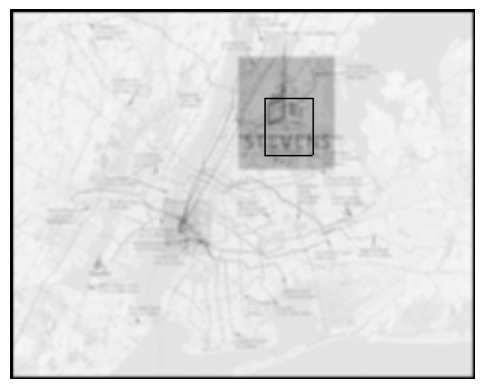

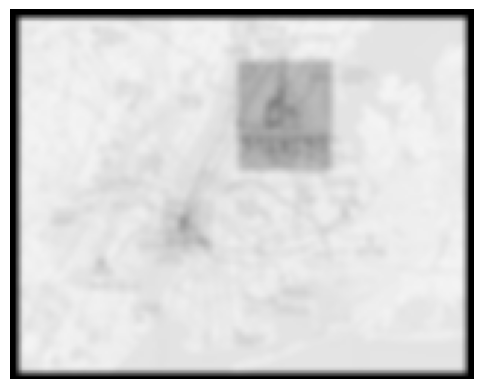

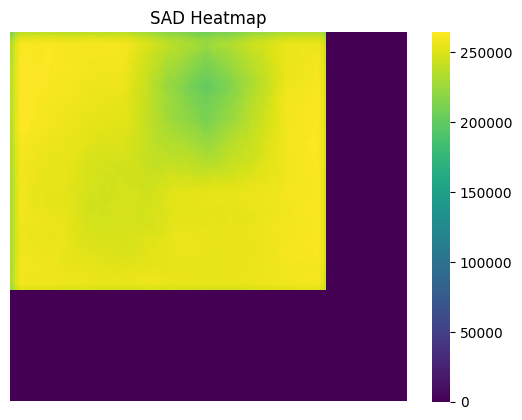

SAD: Found template at 17 78 with cost 202082


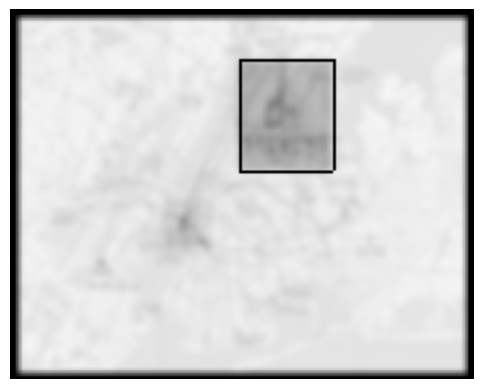

In [11]:
multiscale_template_matching(templ_sad, map_image, smalltempl_image, sigma)

In [12]:
def hough_circles(canvas, r, count, bin_size, theta_step):
  """
  Input- image: H x W
  Input- r: radius
  Input- count: number of votes required to find a circle
  Input- pixel_step: accumulator bin size in pixels
  Input- theta_step: step size in degrees
  Output - N x 2 array of circle centers
  """

  H, W = canvas.shape
  centers = []
  # (x-a)**2 + (y-b)**2 = r**2
  # (x, y) are given, r is known, need to find (a, b)

  # TODO: set up accumulator
  accumulator = np.zeros((H//bin_size, W//bin_size))
  print(accumulator.shape)

  # TODO: collect votes

  for x in range(H):
    for y in range(W):
      if canvas[x, y] == 0:
        for theta in range(0, 180+theta_step, theta_step):
          theta = theta * np.pi/180
          a = int((x - r*np.sin(theta))/bin_size)
          b = int((y - r*np.cos(theta))/bin_size)
          if 0<a<W//bin_size and 0<b<H//bin_size:
            accumulator[b, a] += 1
          a = int((x + r*np.sin(theta))/bin_size)
          b = int((y + r*np.cos(theta))/bin_size)
          if 0<a<W//bin_size and 0<b<H//bin_size:
            accumulator[b, a] += 1


  np.save("pre-accumulator", accumulator)
  accumulator = np.where(accumulator > count, accumulator, 0)
  accumulator = nms(accumulator)
  np.save("accumulator", accumulator)

  for x in range(accumulator.shape[0]):
    for y in range(accumulator.shape[1]):
      if accumulator[x, y] > 0:
        centers.append((x*bin_size, y*bin_size))

  return np.array(centers)

def patch(arr, i, j, p_size):
  p_size = p_size // 2
  return arr[i-p_size:i+p_size+1, j-p_size:j+p_size+1]


def nms(accumulator):
  H, W = accumulator.shape
  patch_size = 9
  res = np.copy(accumulator)
  for i in range(patch_size//2, H-patch_size//2):
    for j in range(patch_size//2, W-patch_size//2):

        # select window based on location of current pixels, look out for index errors
        curr_corner = accumulator[i, j]
        cost_patch = patch(accumulator, i, j, patch_size)

        if curr_corner < cost_patch.max():
          res[i, j] = 0

  return res

def draw_circles(centers, r, step):
  points = list()
  for x, y in centers:
    for theta in range(0, 180+step, step):
      theta = theta * np.pi/180
      a = int(x + r*np.sin(theta))
      b = int(y + r*np.cos(theta))
      points.append((b, a))
      a = int(x - r*np.sin(theta))
      b = int(y - r*np.cos(theta))
      points.append((b, a))
  return np.array(points)

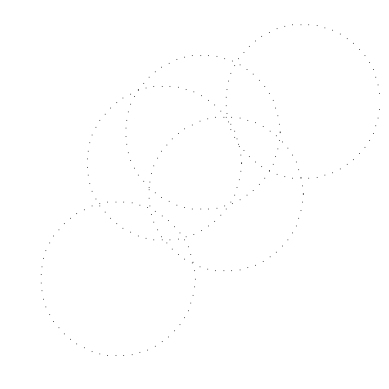

(480, 480)
(68, 68)


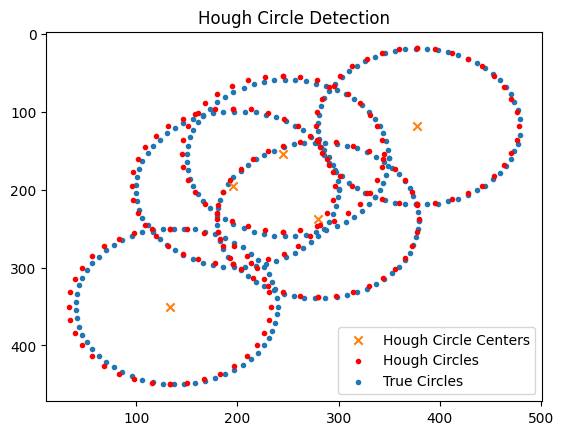

In [13]:
# Hough Circle Detection
circle_image = cv2.imread("circles.png")
circle_image = cv2.cvtColor(circle_image, cv2.COLOR_BGR2GRAY)
imshow(circle_image)
print(circle_image.shape)

# true radius of circles
r = 100

# these values are not necessarily good
count = 12
bin_size = 7
theta_step = 10
centers = hough_circles(circle_image, r, count, bin_size, theta_step)
circle_points = draw_circles(centers, r, theta_step)

true_circle_points_x, true_circle_points_y = np.where(circle_image == 0)
im_ax = plt.scatter(x=true_circle_points_y, y=true_circle_points_x, marker='.')
cc_ax = plt.scatter(x=centers[:, 0], y=centers[:, 1], marker='x')
hc_ax = plt.scatter(x=circle_points[:, 1], y=circle_points[:, 0], c='r', marker='.')
plt.gca().invert_yaxis()
plt.legend([cc_ax, hc_ax, im_ax], ['Hough Circle Centers', 'Hough Circles', 'True Circles'])
plt.title("Hough Circle Detection")
plt.show()

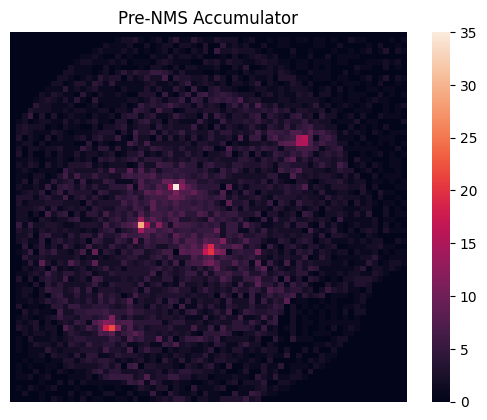

In [14]:
pre_acc = np.load("pre-accumulator.npy")

ax = sns.heatmap(pre_acc)
ax.set(xticks=[],xticklabels=[], xlabel=None, yticks=[], yticklabels=[], ylabel=None)
plt.title("Pre-NMS Accumulator")
plt.show()

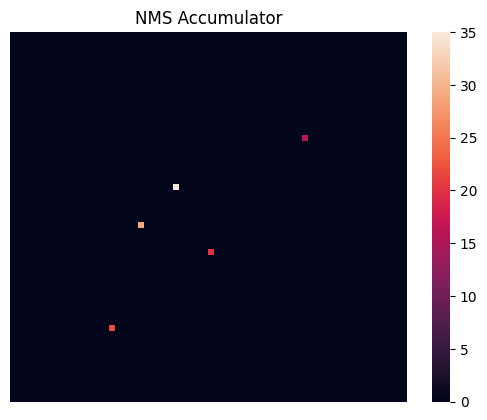

In [15]:
acc = np.load("accumulator.npy")

ax = sns.heatmap(acc)
ax.set(xticks=[],xticklabels=[], xlabel=None, yticks=[], yticklabels=[], ylabel=None)
plt.title("NMS Accumulator")
plt.show()

In [16]:
ax = sns.displot(pre_acc.flatten(), kde=True)
ax.set(xlabel='Votes (log scale)')
plt.title("Distribution of Accumulator")

Text(0.5, 1.0, 'Distribution of Accumulator')